# MDLE - Collaborative Filtering Assignment
### Exercise 1.1
##### Authors: Pedro Duarte 97673, Pedro Monteiro 97484

Import necessary modules

In [1]:
import math

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances

from matplotlib import pyplot as plt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

from operator import add

Declare constants

In [2]:
# Spark Constants
APP_NAME = 'assignment1'
MASTER = 'local[*]'

# Input Constants
INPUT_METADATA_FILE = 'tracks.csv'
INPUT_FEATURES_FILE = 'features.csv'

# Data Columns
COLUMN_TRACK_ID = 'track_id'
COLUMN_SET = 'set'
COLUMN_SUBSET = 'subset'

# Application Constants
SUBSET_SMALL_VALUE = 'small'

Read CSV files and store the data in Pandas dataframes

- tracks: dataset consists of 106,574 music tracks
- features: 518 features, corresponding to 7 statistics (mean, standard deviation, skew, kurtosis, median, minimum, maximum) calculated from 74 time-based acoustic characteristics

In [3]:
tracks = pd.read_csv(INPUT_METADATA_FILE, index_col=0, header=[0, 1]) # has 2 header rows
features = pd.read_csv(INPUT_FEATURES_FILE, index_col=0, header=[0, 1, 2]) # has 3 header rows

Filter the `tracks` dataframe:

- condition checks if the value in the subset column of the set multi-level column index is equal to the string `small`.

After that is expected to have only 8000 rows.

In [4]:
small = tracks[tracks[COLUMN_SET, COLUMN_SUBSET] == SUBSET_SMALL_VALUE]
small.shape # get shape of dataframe => 8000 rows

(8000, 52)

Create a python set `ids` which contains the elements of the index of the `small` Pandas DataFrame

In [5]:
ids = set(small.index.to_list())

Select the `rows` from features dataframe that have an index in `ids`

In [6]:
features_sm = features.loc[ids]
features_sm.shape # get shape of dataframe => (8000, 518)
                  # should be 8000 tracks and 518 features

/tmp/ipykernel_116402/89041036.py:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  features_sm = features.loc[ids]


(8000, 518)

Use the StandardScaler, from scikit-learn, to standardize the values of `features_sm` dataframe

In [7]:
X = features_sm.values # extracts the values from the features dataframe 
X = StandardScaler().fit(X).transform(X) # X standardization

Configuration and Initialization of Spark

- Parameters:
    - `APP_NAME` (string): the name of the Spark application
    - `MASTER` (string): the URL of the Spark master node
<br></br>
- Returns:
    - `sc` (SparkContext): the Spark context for the given application and master
    - `spark` (SparkSession): the Spark session for the given application and master

In [8]:
conf = SparkConf().setAppName(APP_NAME).setMaster(MASTER)
sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession.builder.appName(APP_NAME).master(MASTER).getOrCreate()

23/05/05 00:40:24 WARN Utils: Your hostname, pedro resolves to a loopback address: 127.0.1.1; using 192.168.0.12 instead (on interface wlo1)
23/05/05 00:40:24 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/05 00:40:25 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Perform Agglomerative Clustering on the small dataset 

In [9]:
results = {} # dictionary to save metric results

for k in range(8, 17):
    clusters = AgglomerativeClustering(n_clusters=k).fit_predict(X)

    # get the clusters separated
    clusters_separated = [X[clusters == i] for i in range(k)]

    # create each centroid with the mean of all cluster points
    centroids = [cluster.mean(axis=0) for cluster in clusters_separated]

    # calculate radius with euclidian distance between all points and the centroid
    # radius is the max distance
    radius = [max(np.linalg.norm(p - centroids[i]) for p in clusters_separated[i]) for i in range(k)]

    # calculate diameter, being the max distance between all points in the same cluster
    diameter = [np.max(pairwise_distances(cluster)) for cluster in clusters_separated]

    # calculate density with radius, checking if radius is not 0
    density_r = [len(clusters_separated[i]) / (radius[i]**2) if radius[i] != 0 else math.inf for i in range(k)]
    # calculate density with diameter, checking if diameter is not 0
    density_d = [len(clusters_separated[i]) / (diameter[i]**2) if diameter[i] != 0 else math.inf for i in range(k)]

    # save results on a dictionary to be used later
    results[k] = {
        'centroids': centroids,
        'radius': radius,
        'diameter': diameter,
        'density_r': density_r,
        'density_d': density_d,
    }

    print(f'For k = {k}:')
    print('Radius:', radius)
    print('Diameter:', diameter)
    print('Density (r2):', density_r)
    print('Density (d2):', density_d)
    print()

For k = 8:
Radius: [131.9635070863535, 85.61707555250149, 57.70367758776073, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0]
Diameter: [173.98817814544742, 104.32765325996061, 78.29800458030583, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0]
Density (r2): [0.12604534947908394, 0.19426260600852557, 0.9247039305792399, 0.005681947844095345, 0.3622980347779691, inf, 0.015423575461012385, inf]
Density (d2): [0.07250952221003852, 0.13083113598178184, 0.502236533071095, 0.003485202408848669, 0.1803807122132652, inf, 0.009909679658004903, inf]

For k = 9:
Radius: [57.70367758776073, 85.61707555250149, 131.53468744381067, 108.58973665171192, 56.55991248912924, 0.0, 69.26651356236508, 0.0, 73.19915536057896]
Diameter: [78.29800458030583, 104.32765325996061, 173.98817814544742, 138.6511252678381, 80.15796245946396, 0.0, 86.41438670574432, 0.0, 93.5137932752037]
Density (r2): [0.9247039305792399, 0.19426260600852557, 0.05670069902810301, 0.00568194784409534

### 1.2

Create Scatter Plots with the density r² and d² values for each k

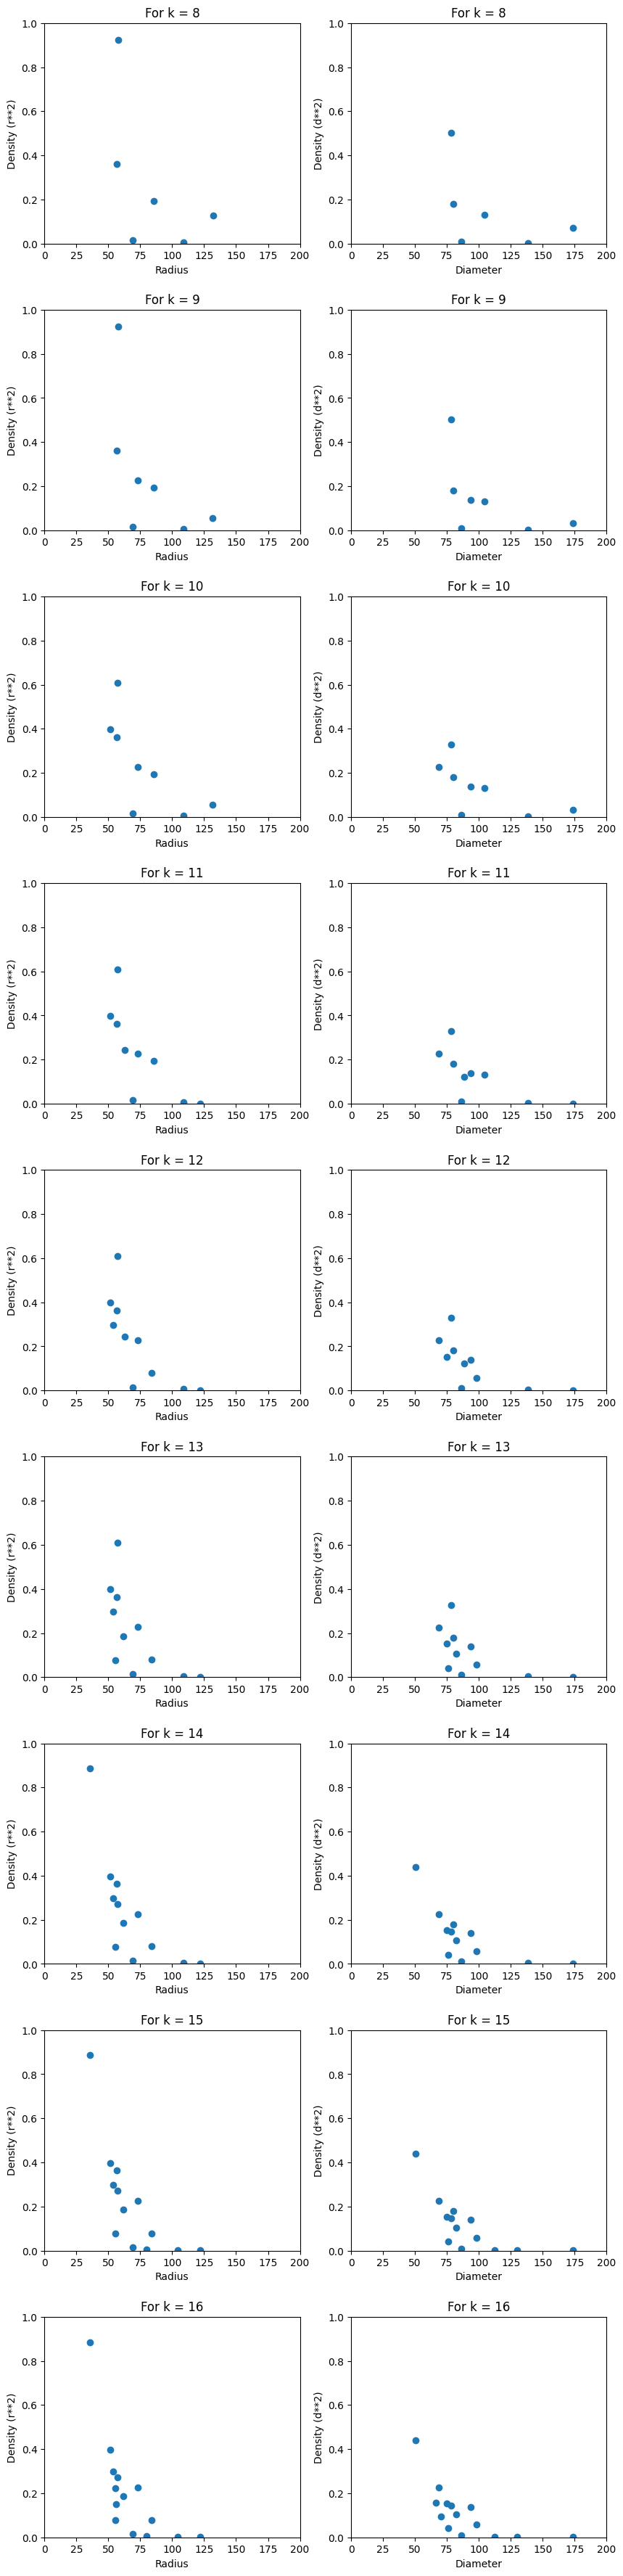

In [10]:
ks = list(results.keys())
fig = plt.figure()

fig.set_figwidth(10)
fig.set_figheight(45)
fig.set_animated(True)
fig.subplots_adjust(hspace=.3)

for i in range(len(ks)):
  k = ks[i]

  # for both radius and diameter check if there are densities that are inf and remove (add to invalid idx)
  invalid_idxs = [i for i in range(len(results[k]['radius'])) if results[k]['density_r'][i] == math.inf]
  radius_results = [results[k]['radius'][i] for i in range(len(results[k]['radius'])) if i not in invalid_idxs]
  density_r_results = [results[k]['density_r'][i] for i in range(len(results[k]['density_r'])) if i not in invalid_idxs]

  invalid_idxs = [i for i in range(len(results[k]['diameter'])) if results[k]['density_d'][i] == math.inf]
  diameter_results = [results[k]['diameter'][i] for i in range(len(results[k]['diameter'])) if i not in invalid_idxs]
  density_d_results = [results[k]['density_d'][i] for i in range(len(results[k]['density_d'])) if i not in invalid_idxs]

  # plot density r² for each k
  sub_r = fig.add_subplot(len(ks), 2, 2*i+1)
  sub_r.scatter(radius_results, density_r_results)
  sub_r.set_xlabel('Radius')
  sub_r.set_ylabel('Density (r**2)')
  sub_r.set_title(f'For k = {k}')
  sub_r.set_xlim([0, 200])
  sub_r.set_ylim([0, 1])

  # plot density d² for each k
  sub_d = fig.add_subplot(len(ks), 2, 2*i+2)
  sub_d.scatter(diameter_results, density_d_results)
  sub_d.set_xlabel('Diameter')
  sub_d.set_ylabel('Density (d**2)')
  sub_d.set_title(f'For k = {k}')
  sub_d.set_xlim([0, 200])
  sub_d.set_ylim([0, 1])

plt.show()

Create Scatter Plots for the mean density (r² and d²) for each k 

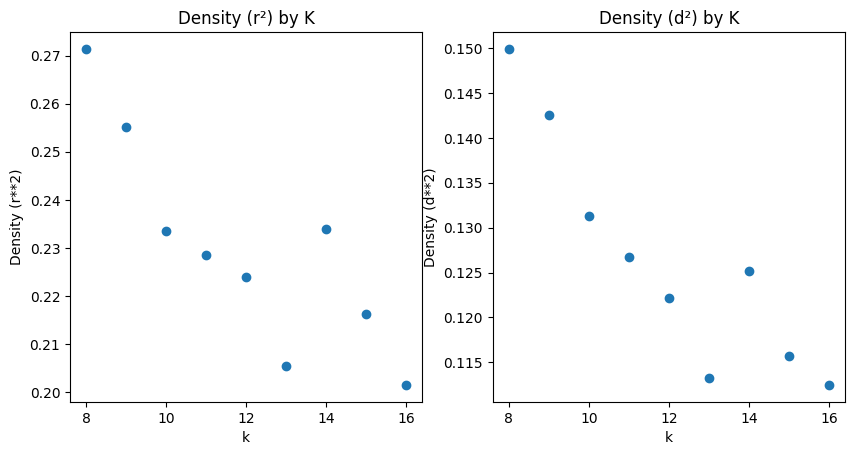

In [11]:
ks = list(results.keys())
fig = plt.figure()

fig.set_figwidth(10)
fig.set_animated(True)

valid_r_ds = { k: [d for d in results[k]['density_r'] if d != math.inf] for k in ks } # get density r² values (remove inf)
valid_d_ds = { k: [d for d in results[k]['density_d'] if d != math.inf] for k in ks } # get density d² values (remove inf)

sub_r = fig.add_subplot(1, 2, 1)
sub_r.scatter(ks, [sum(valid_r_ds[k])/len(valid_r_ds[k]) for k in ks]) # get the mean density r²
sub_r.set_xlabel('k')
sub_r.set_ylabel('Density (r**2)')
sub_r.set_title(f'Density (r²) by K')

sub_d = fig.add_subplot(1, 2, 2)
sub_d.scatter(ks, [sum(valid_d_ds[k])/len(valid_d_ds[k]) for k in ks]) # get the mean density d²
sub_d.set_xlabel('k')
sub_d.set_ylabel('Density (d**2)')
sub_d.set_title(f'Density (d²) by K')

plt.show()

Create a function that calculates the Mahalanobis distance between two points using the inverse covariance matrix, according to the formula:
            
- d(x, c) = d ∑ i=1 √(xi - ci/σi)²

In [12]:
def mahalanobis_distance(x, y, inv_cov):
    diff = (x - y) / np.sqrt(np.diag(inv_cov))
    return np.sqrt(np.dot(diff, diff))

Create the BFR algorithm function

In [13]:
import numpy as np
from scipy.spatial.distance import mahalanobis

def bfr(dataset, k, threshold):
    # get previous k centroids, defined with AglomerativeClustering
    centroids = np.array(results[k]['centroids'])

    # get the inverse of the covariance matrix
    inv_cov_matrix = np.linalg.inv(np.cov(dataset.T)) # np.cov(dataset.T) -> covariance matrix

    # assign each point to the nearest centroid using Mahalanobis Distance
    centroid_distances = [([mahalanobis_distance(point, centroid, inv_cov_matrix) 
                            for centroid in centroids], point) 
                            for point in dataset]
    
    # assign to the cluster only the points that are below the distance threshold
    centroid_distances = [np.argmin(distances) 
                          if np.min(distances) < threshold*np.std(point) 
                          else None 
                          for distances, point in centroid_distances]
    
    assignments = np.array(centroid_distances)
    centroids = np.array([dataset[assignments == i].mean(axis=0) for i in range(k)])

    return centroids, assignments


Apply `StandardScaler` from scikit-learn to complete dataset standardization

In [14]:
X_full = features.values # get complete dataset values
X_full = StandardScaler().fit(X_full).transform(X_full) # values standardization

**We choose k=8**
- highest density cluster (denser cluster)
- smaller values ​​for both the radius and the diameter
- smaller values ​​of k present more efficient results because fewer iterations are required

Apply the BFR algorithm, previously created <br>
Parameters:
- `X_full`: dataset values
- `k`: number of clusters
- `threshold`: factor to be applied to standard deviation to decide which points belong to the cluster

In [18]:
k=8
centroids, cluster_idxs = bfr(X_full, k, 30)

Create a function to plot a bar chart of the music genres distribution for a given cluster <br>
Parameters:
- `ax`: matplotlib axis object representing the subplot where the chart will be drawn
- `clusterid`:  integer representing the ID of the cluster to plot

In [16]:
def plot_genres_chart_info(ax, clusterid):
  # retrieve tracks indices that belong to the specific cluster
  cluster_ids = features[cluster_idxs == clusterid].index.to_list() 

  # remove empty genres
  cluster_genres = tracks.loc[cluster_ids]['track', 'genre_top'].dropna().tolist()

  # count the occurrences of each genre in the list
  cluster_genres = sc.parallelize(cluster_genres).map(lambda v: (v, 1)).reduceByKey(add).collectAsMap()

  # sort genres to plot first the genres with more items
  sorted_genres = {k: v for k, v in sorted(cluster_genres.items(), key=lambda item: item[1], reverse=True)}

  ax.bar([str(key) for key in sorted_genres.keys()], sorted_genres.values())
  ax.set_xticklabels([str(key) for key in cluster_genres.keys()], rotation=90) # rotate x-labels

Create the genres plots using the previous function

/tmp/ipykernel_116402/1364453750.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(key) for key in cluster_genres.keys()], rotation=90) # rotate x-labels
/tmp/ipykernel_116402/1364453750.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(key) for key in cluster_genres.keys()], rotation=90) # rotate x-labels
/tmp/ipykernel_116402/1364453750.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(key) for key in cluster_genres.keys()], rotation=90) # rotate x-labels
/tmp/ipykernel_116402/1364453750.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(key) for key in cluster_genres.keys()], rotation=90) # rotate x-labels
/tmp/ipykernel_116402/1364453750.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(key) for ke

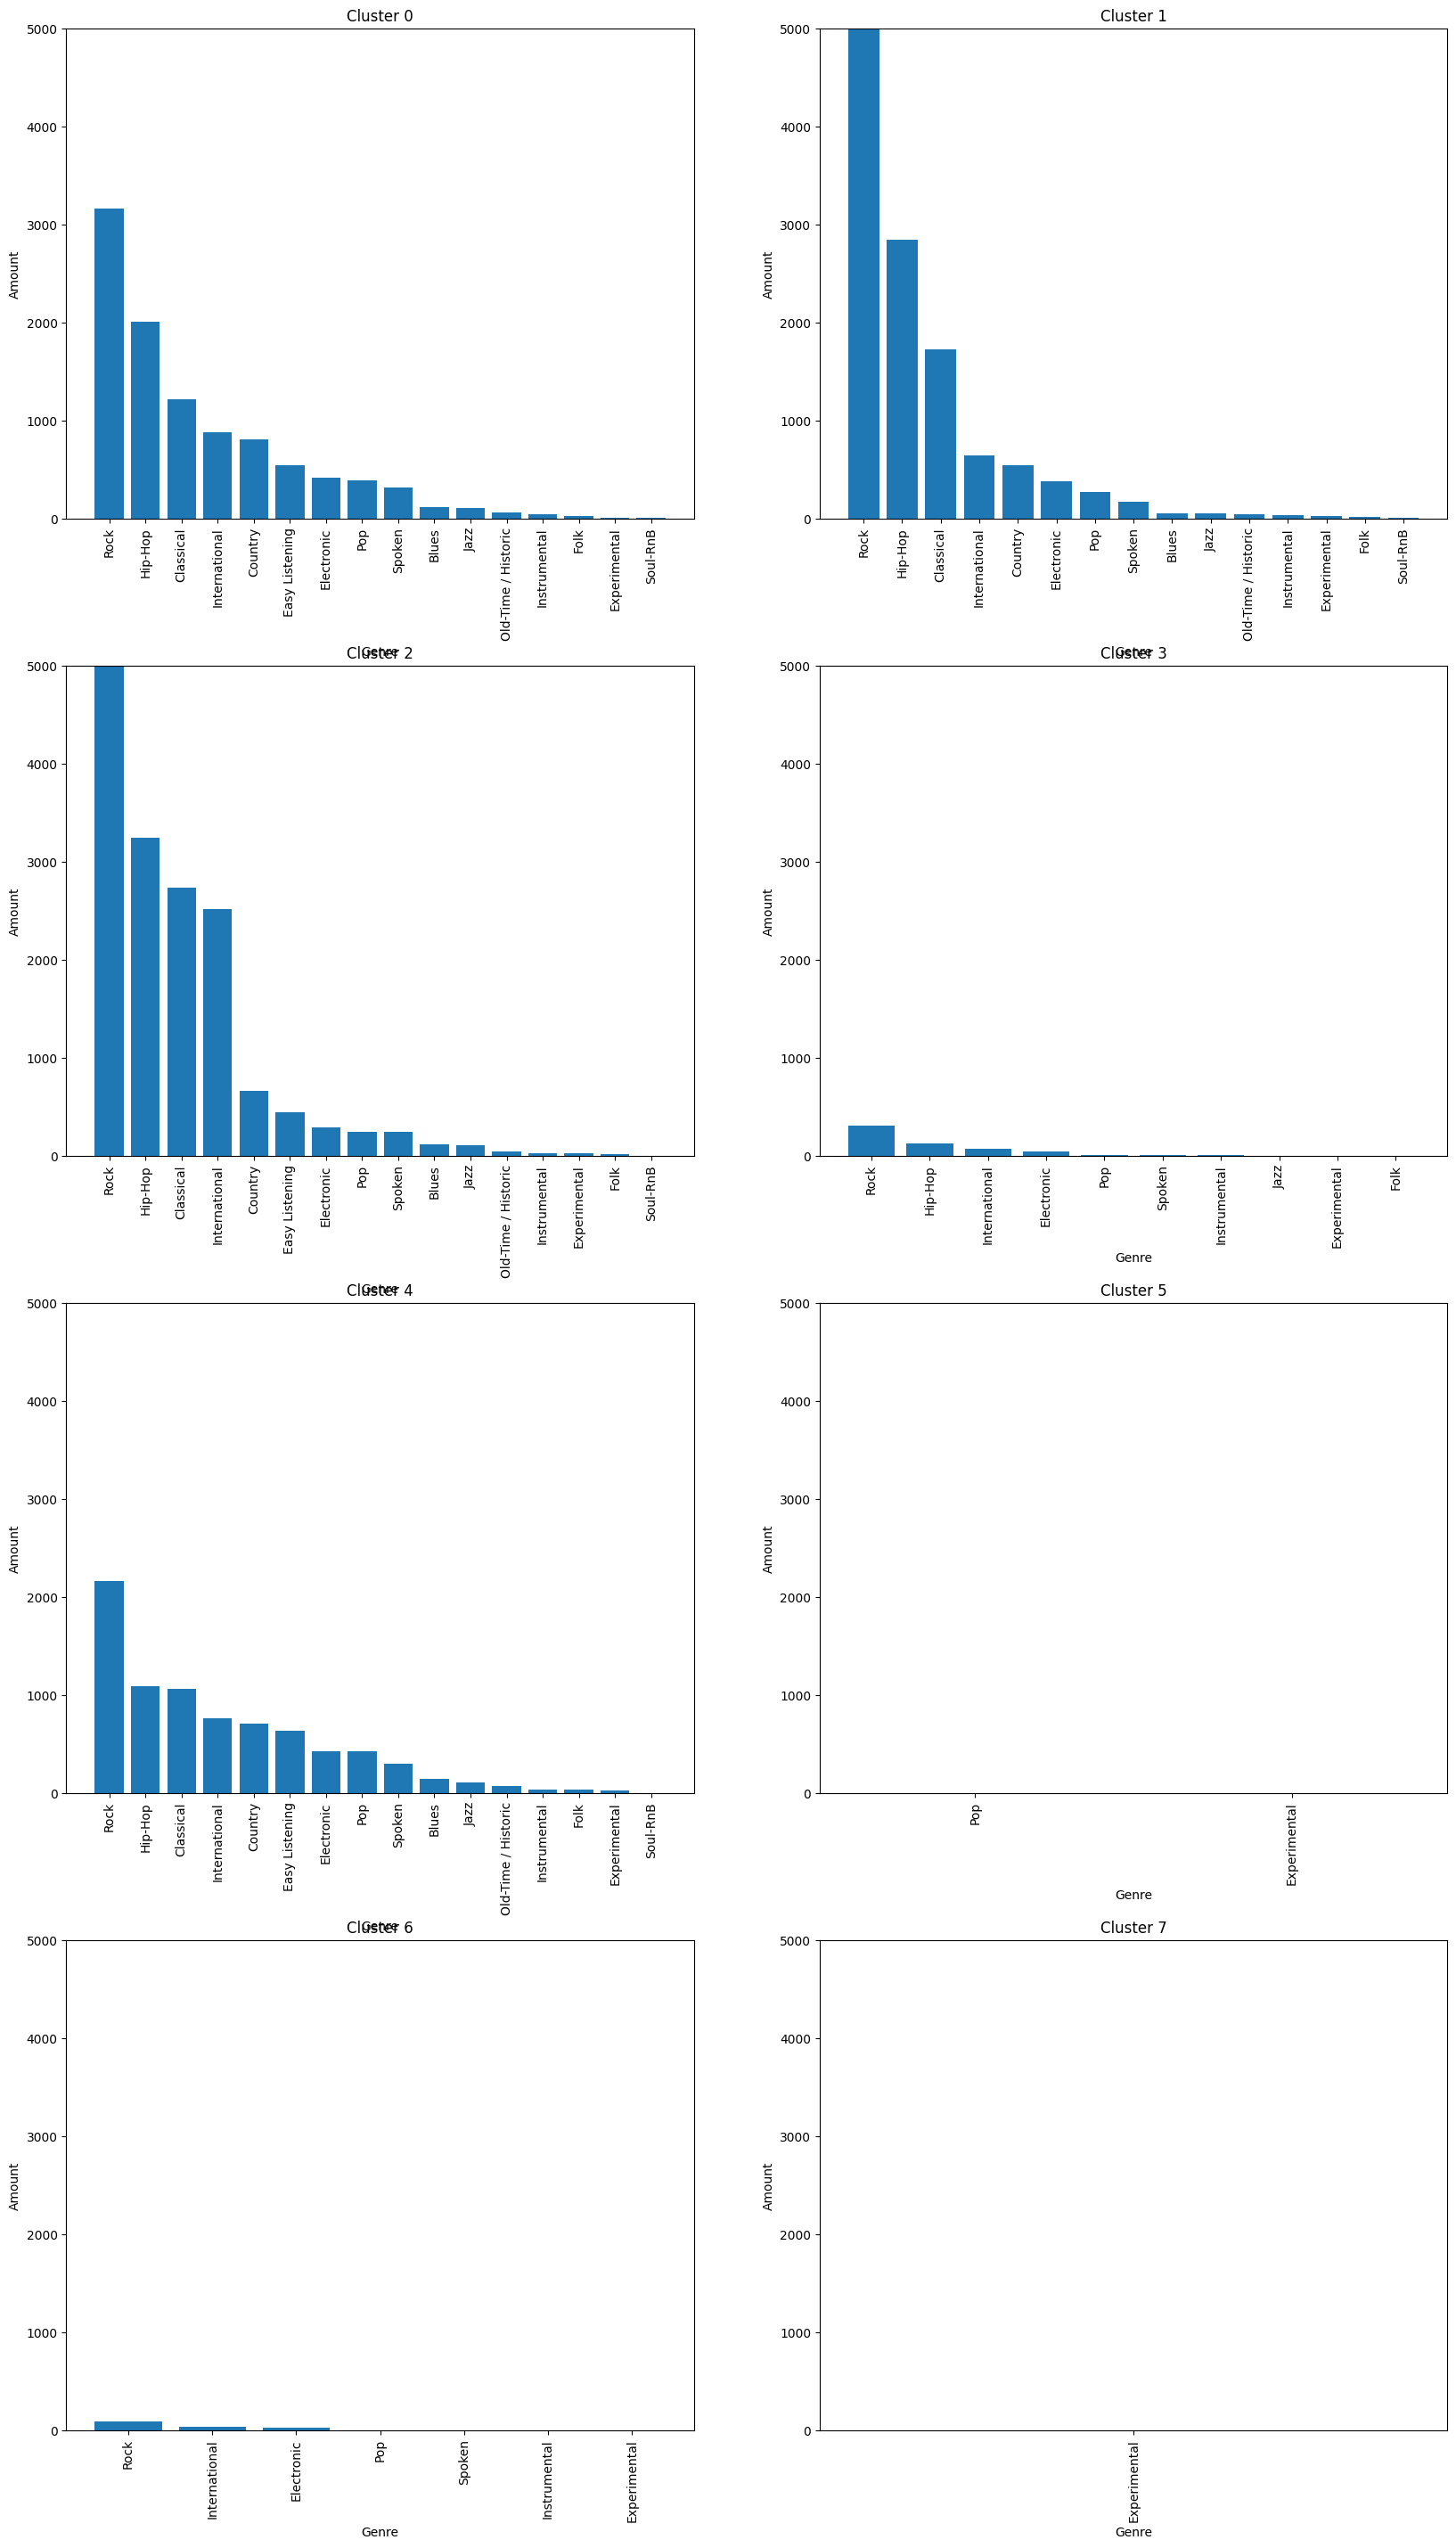

In [17]:
fig = plt.figure()

fig.set_figwidth(20)
fig.set_figheight(35)
fig.set_animated(True)
fig.subplots_adjust(hspace=.3)

k = 8 # number of clusters choosen

for i in range(k):
  ax = fig.add_subplot(math.ceil(k/2), 2, i+1)
  plot_genres_chart_info(ax, i)
  ax.set_ylim([0, 5000])
  ax.set_xlabel('Genre')
  ax.set_ylabel('Amount')
  ax.set_title(f'Cluster {i}')

plt.show()